In [21]:
#import modules
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.metrics import precision_score,accuracy_score
from sklearn.feature_selection import SelectKBest,chi2,f_classif

In [22]:
#import datafiles
#look at the feature extraction technique with the best test accuracy
# Moran

In [23]:
seq_file = '../data/enz_sequence.csv'
label_file = '../data/enz_labels.csv'

In [29]:
df1 = pd.read_csv(seq_file,header=None)
df2 = pd.read_csv(label_file,header=None)
df = df1.merge(df2,on=0)

def filter_by_len(seq):
    val = len(seq)
    if val>200 and val<600:
        return True
    return False

df = df.loc[df['1_x'].apply(filter_by_len)]
# create a smaller test-train
df_0 = df.loc[df.iloc[:,-1]==0]
df_1 = df.loc[df.iloc[:,-1]==1]
train_df0 = df_0.sample(n=int(0.75*(len(df_0))),random_state=42)
valid_df0 = df_0.loc[~df_0.isin(train_df0)[0]]
train_df1 = df_1.sample(n=int(0.6*(len(df_1))),random_state=42)
valid_df1 = df_1.loc[~df_1.isin(train_df1)[0]]
train_df = pd.concat([train_df0,train_df1])
valid_df = pd.concat([valid_df0,valid_df1])
train_df = train_df.sample(frac=1,random_state=42)
valid_df = valid_df.sample(frac=1,random_state=42)

In [30]:
np.unique(df['1_y'].values,return_counts=True)

(array([0, 1]), array([2256, 3777]))

In [5]:
feat_vec = '../featEngg/offline/ifeatMethods/data/featvec/trainfiles/CKSAAGP.csv.gz'
label_file = '../data/enz_labels.csv'

In [6]:
df1 = pd.read_csv(feat_vec,header=None)
df2 = pd.read_csv(label_file,header=None)
df = df1.merge(df2,on=0)

In [7]:
train_df = df.loc[df[0].isin(train_df[0].values)]
valid_df = df.loc[df[0].isin(valid_df[0].values)]

In [8]:
#define data
testenz_names = valid_df.iloc[:,0].values
X_test = valid_df.iloc[:,1:-1].values
y_test = valid_df.iloc[:,-1].values

In [9]:
#define data
enz_names = train_df.iloc[:,0].values
X = train_df.iloc[:,1:-1].values
y = train_df.iloc[:,-1].values

In [10]:
# train test split
X_train, X_valid, y_train, y_valid, enz_train, enz_valid = train_test_split(X, y, enz_names, 
                        test_size=0.1, random_state=42)

In [11]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([1123, 1516]))

In [12]:
def dt_clf(max_depth):
    dt = DecisionTreeClassifier(max_features='auto',
                                max_depth=max_depth,random_state=42)
    dt.fit(X_train,y_train)
    return dt.score(X_valid,y_valid)

In [13]:
pool = mp.Pool(mp.cpu_count())
depths = [21,55,65,75,90,120,240]
scrs = list(pool.map(dt_clf,depths))

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

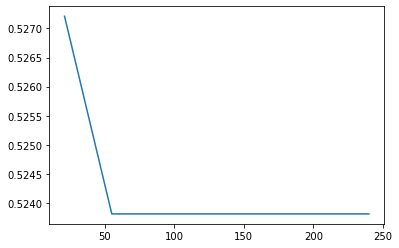

In [15]:
plt.plot(depths,scrs)

In [16]:
max(scrs)

0.5272108843537415

In [17]:
# random forests
def rf_clf(n_est):
    rf = RandomForestClassifier(n_estimators = n_est,
                                max_features='auto',
                                max_depth=3,
                                random_state=42,
                               class_weight='balanced',
                               max_samples=100)
    rf.fit(X_train,y_train)
    return rf.score(X_valid,y_valid)

In [18]:
pool = mp.Pool(mp.cpu_count())
est = [120,150,225,325,340,355,375,400,425,455,475,500,575,590,700]
scrs_rf = list(pool.map(rf_clf,est))

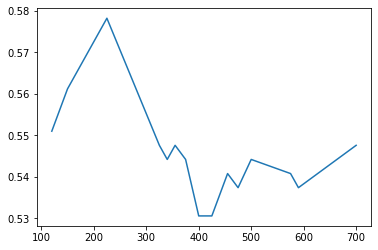

In [19]:
plt.plot(est,scrs_rf)

In [20]:
max(scrs_rf),max(scrs)

(0.5782312925170068, 0.5272108843537415)

In [21]:
def get_rfclf(n_est):
    rf = RandomForestClassifier(n_estimators = n_est,
                                max_features='auto',
                                max_depth=3,
                                random_state=42,
                               class_weight='balanced',
                               max_samples=100)
    rf.fit(X_train,y_train)
    return rf

In [22]:
myrf = get_rfclf(355)

In [23]:
myrf.score(X_valid,y_valid),myrf.score(X_test,y_test)

(0.5680272108843537, 0.7086307592472421)

In [24]:
np.unique(myrf.predict(X_valid),return_counts=True)

(array([0, 1]), array([ 12, 282]))

In [25]:
np.unique(y_valid,return_counts=True)

(array([0, 1]), array([125, 169]))

In [26]:
np.unique(myrf.predict(X_test),return_counts=True)

(array([0, 1]), array([  79, 1462]))

In [27]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([ 417, 1124]))

In [30]:
precision_score(y_test,myrf.predict(X_test),pos_label=0),precision_score(y_valid,myrf.predict(X_valid),pos_label=0)

(0.31724137931034485, 0.3333333333333333)

In [34]:
# svm
def svc_clf(regC):
    svc = SVC(C = regC,
            kernel='rbf',
            decision_function_shape='ovo',
            random_state=42,
            class_weight=None)
    svc.fit(X_train,y_train)
    return svc.score(X_valid,y_valid)

In [35]:
pool = mp.Pool(mp.cpu_count())
c_param = [1,1.25,1.5,3,5,7,10,20,25,35,100]
scrs_svc = list(pool.map(svc_clf,c_param))

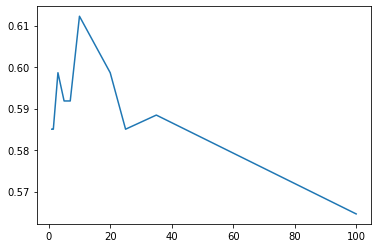

In [36]:
plt.plot(c_param,scrs_svc)

In [37]:
max(scrs_svc)

0.6122448979591837

In [45]:
# gradient boosted trees
def gbt_clf(n_est):
    gbt = GradientBoostingClassifier(n_estimators = n_est,
                                max_features='auto',
                                max_depth=3,
                                random_state=42,
                                learning_rate=0.1,
                                subsample=1)
    gbt.fit(X_train,y_train)
    return gbt.score(X_valid,y_valid)

In [46]:
pool = mp.Pool(mp.cpu_count())
est = [120,150,225,325,340,355,375,400,425,455,475,500,575,590,700]
scrs_gbt = list(pool.map(gbt_clf,est))

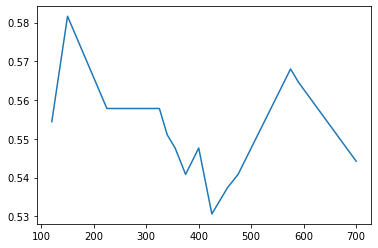

In [47]:
plt.plot(est,scrs_gbt)

In [48]:
max(scrs_gbt)

0.5816326530612245

In [59]:
# NN
def nn_clf(hl):
    nn = MLPClassifier(hidden_layer_sizes = hl,
                        alpha= 0.005,
                        random_state=42,
                        learning_rate='adaptive',
                        learning_rate_init=0.01,
                      max_iter=1000,
                      early_stopping=True)
    nn.fit(X_train,y_train)
    return nn.score(X_test,y_test)

In [60]:
pool = mp.Pool(mp.cpu_count())
hls = [(10,),(50,),(100,),(125,),(135,),(150,),(250,),(350,),(375,),
      (10,5,),(100,50,),(125,75,),(350,150,),
      (100,75,50,25,15,),(125,95,70,35,5)]
scrs_nn = list(pool.map(nn_clf,hls))

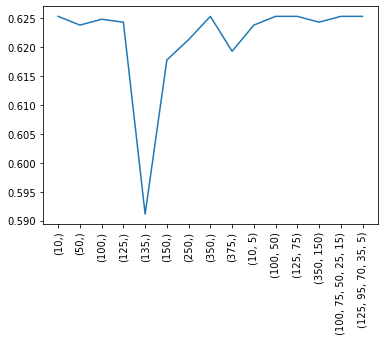

In [61]:
plt.plot(scrs_nn)
plt.xticks(range(len(hls)),hls,rotation=90);

In [62]:
max(scrs_nn)

0.6253139126067303

In [65]:
nn = MLPClassifier(hidden_layer_sizes = (100,75,50,25,15,),
                        alpha= 0.005,
                        random_state=42,
                        learning_rate='adaptive',
                        learning_rate_init=0.01,
                      max_iter=1000,
                      early_stopping=True)
nn.fit(X_train,y_train)

MLPClassifier(alpha=0.005, early_stopping=True,
              hidden_layer_sizes=(100, 75, 50, 25, 15),
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000,
              random_state=42)

In [69]:
np.unique(nn.predict(X_test),return_counts=True)

(array([1]), array([1991]))

In [70]:
nn.score(X_test,y_test)

0.6253139126067303

In [71]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([ 746, 1245]))

In [76]:
# under sampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled,y_train_resampled = rus.fit_resample(X_train,y_train)

In [79]:
nn = MLPClassifier(hidden_layer_sizes = (100,75,50,25,15,),
                        alpha= 0.005,
                        random_state=42,
                        learning_rate='adaptive',
                        learning_rate_init=0.01,
                      max_iter=1000,
                      early_stopping=True)
nn.fit(X_train_resampled,y_train_resampled)

MLPClassifier(alpha=0.005, early_stopping=True,
              hidden_layer_sizes=(100, 75, 50, 25, 15),
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000,
              random_state=42)

In [80]:
nn.score(X_test,y_test)

0.48518332496233046

In [81]:
np.unique(nn.predict(X_test),return_counts=True)

(array([0, 1]), array([1161,  830]))

In [82]:
nn.predict(X_test)

array([0, 0, 1, ..., 1, 0, 1])

In [83]:
y_test

array([1, 0, 1, ..., 1, 0, 1])

In [90]:
over = SMOTE(sampling_strategy=)
under = RandomUnderSampler(sampling_strategy='auto')
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train_resampled,y_train_resampled = pipeline.fit_resample(X_train,y_train)

In [113]:
smote_ = SMOTETomek(random_state=0)
X_train_resampled,y_train_resampled = smote_.fit_resample(X_train,y_train)

In [203]:
skbest = SelectKBest(f_classif, k=80)
X_tr_best = skbest.fit_transform(X_train_resampled,y_train_resampled)
X_te_best = skbest.transform(X_test)

In [204]:
np.unique(y_train_resampled,return_counts=True)

(array([0, 1]), array([2442, 2442]))

In [205]:
nn = MLPClassifier(hidden_layer_sizes = (100,55,15),
                        alpha= 0.005,
                        random_state=42,
                        learning_rate='adaptive',
                        learning_rate_init=0.01,
                      max_iter=1000,
                      early_stopping=True)
nn.fit(X_tr_best,y_train_resampled)

MLPClassifier(alpha=0.005, early_stopping=True,
              hidden_layer_sizes=(100, 55, 15), learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=1000, random_state=42)

In [206]:
nn.score(X_te_best,y_test)

0.5740833751883475

In [207]:
np.unique(nn.predict(X_te_best),return_counts=True)

(array([0, 1]), array([ 534, 1457]))

In [208]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([ 746, 1245]))

In [209]:
accuracy_score(nn.predict(X_te_best),y_test)

0.5740833751883475

In [210]:
yhat = nn.predict(X_te_best)

In [211]:
yhat[:10],y_test[:10]

(array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1]), array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1]))

In [212]:
tp = 0
fp = 0
for i,j in zip(yhat,y_test):
    if i==j==0:
        tp+=1
    if i==0 and j!=0:
        fp+=1

In [213]:
tp/(tp+fp)

0.4044943820224719

In [214]:
precision_score(y_test,nn.predict(X_te_best),pos_label=0)

0.4044943820224719